In [1]:
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
variants_file = "/data5/UK_Biobank/annotations/vep/2022_03_13/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
variants_df = pd.read_csv(variants_file, sep="\t", low_memory=False, usecols=["Sample", "variant_id", "Gene", "SYMBOL", "Mut_type"], dtype=str)

In [10]:
# get combos that contain genes which can cause both high and low bmi
combo2_file = "/data5/UK_Biobank/bmi_project/combinations/all_combinations/for_manuscript/combos_of_length_2.csv"
combo3_file = "/data5/UK_Biobank/bmi_project/combinations/all_combinations/for_manuscript/combos_of_length_3.csv"

low_bmi_combo2_file = "/data5/deepro/ukbiobank/analysis/bmi_project/protective/data/tables/noicd10_combos2.tsv"
low_bmi_combo3_file = "/data5/deepro/ukbiobank/analysis/bmi_project/protective/data/tables/noicd10_combos3.tsv"

In [11]:
figsavedir = "/data5/deepro/ukbiobank/analysis/bmi_project/protective/data/figures/bothpheno_varid"

In [5]:
def parse_combo_df(combo2_file, combo3_file, pheno, group, sep=","):
    combo2_df = pd.read_csv(combo2_file, usecols=["Phenotype", "Group", "Item_1", "Item_2", "Item_1_symbol", "Item_2_symbol", "Case_Samples"], sep=sep)
    combo2_df["Item_3"] = ""
    combo2_df["Item_3_symbol"] = ""
    combo3_df = pd.read_csv(combo3_file, usecols=["Phenotype", "Group", "Item_1", "Item_2", "Item_3", "Item_1_symbol", "Item_2_symbol", "Item_3_symbol", "Case_Samples"], sep=sep)
    combo_df = pd.concat((combo2_df, combo3_df))
    combo_df = combo_df.loc[(combo_df.Phenotype==pheno)&(combo_df.Group==group)]
    return combo_df.loc[:, ["Phenotype", "Group", "Item_1", "Item_2", "Item_3", "Item_1_symbol", "Item_2_symbol", "Item_3_symbol", "Case_Samples"]].reset_index(drop=True)

In [6]:
high_bmi_df = parse_combo_df(combo2_file, combo3_file, "high_bmi", "white_british")

In [12]:
low_bmi_df = parse_combo_df(low_bmi_combo2_file, low_bmi_combo3_file, "low_bmi", "white_british", sep="\t")

In [16]:
def get_genes_from_df(df):
    geneset = set([g for g in df.loc[:, [f"Item_{i}_symbol" for i in range(1, 4)]].values.flatten() if g])
    return geneset

def get_geneids_from_df(df):
    geneset = set([g for g in df.loc[:, [f"Item_{i}" for i in range(1, 4)]].values.flatten() if g])
    return geneset

In [14]:
high_bmi_genes = get_genes_from_df(high_bmi_df)
low_bmi_genes = get_genes_from_df(low_bmi_df)

In [15]:
both_pheno_genes = high_bmi_genes.intersection(low_bmi_genes)

In [17]:
high_bmi_geneids = get_geneids_from_df(high_bmi_df)
low_bmi_geneids = get_geneids_from_df(low_bmi_df)

In [18]:
both_pheno_geneids = high_bmi_geneids.intersection(low_bmi_geneids)

In [11]:
both_pheno_df = pd.concat((high_bmi_df, low_bmi_df))
both_pheno_df = both_pheno_df.loc[(both_pheno_df.Item_1_symbol.isin(both_pheno_genes))|((both_pheno_df.Item_2_symbol.isin(both_pheno_genes)))|((both_pheno_df.Item_3_symbol.isin(both_pheno_genes)))].reset_index(drop=True)

In [12]:
def get_gene_specific_combo_info(df, gene):
    df = df.loc[(df.Item_1_symbol==gene)|((df.Item_2_symbol==gene))|((df.Item_3_symbol==gene))].reset_index(drop=True)
    return df

def get_case_samples(df):
    high_pheno_cases = ",".join(df.loc[df.Phenotype=="high_bmi"].Case_Samples.str.strip('"').values.flatten()).split(",")
    low_pheno_cases = ",".join(df.loc[df.Phenotype=="low_bmi"].Case_Samples.str.strip('"').values.flatten()).split(",")
    return high_pheno_cases, low_pheno_cases


In [13]:
def create_var_loc_plot(high_bmi_var_df, low_bmi_var_df, gene_name, save_dir):
    low_bmi_var_df = low_bmi_var_df.pivot_table(
        index="variant_id", 
        values=["Sample", "Mut_type"], 
        aggfunc={"Sample": lambda x: len(x), "Mut_type": lambda x: list(x)[0]}
        )
    low_bmi_var_df["pheno"] = "low_bmi"

    high_bmi_var_df = high_bmi_var_df.pivot_table(
        index="variant_id", 
        values=["Sample", "Mut_type"], 
        aggfunc={"Sample": lambda x: len(x), "Mut_type": lambda x: list(x)[0]}
        )
    high_bmi_var_df["pheno"] = "high_bmi"
    var_df = pd.concat((low_bmi_var_df, high_bmi_var_df)).reset_index().sort_values(by="variant_id")
    plot_df = var_df.pivot_table(index=["variant_id", "Mut_type"], values="Sample", columns="pheno").fillna(0)
    
    ticklabelcolor_dict = {"lof": "red", "missense":"purple"}
    barcolor_dict = {"low_bmi": "burlywood", "high_bmi": "chocolate"}
    
    fig, ax = plt.subplots(figsize=(len(plot_df)//4 + 1.5, 4))

    plot_df.plot(kind="bar", stacked=True, color=[barcolor_dict[x] for x in plot_df.columns], ax=ax, fontsize=10, )
    ax.xaxis.set_tick_params(width=1.5, size=5)
    ax.yaxis.set_tick_params(width=1.5, size=5)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("")
    for tick_label in ax.get_xticklabels():
        var_id = tick_label.get_text().strip("(").strip(")").split(",")
        var_type = var_id[1].strip()
        tick_label.set_text(var_id[0])
        tick_label.set_color(ticklabelcolor_dict[var_type])
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(gene_name)
    
    save_file = os.path.join(save_dir, f"{gene_name}.pdf")
    print(f"Saving to {save_file}")
    pdf_store = PdfPages(save_file)
    pdf_store.savefig(fig, bbox_inches='tight')
    pdf_store.close()
    return 

Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/HLA-DRB1.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/SCN10A.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/RYR1.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/CACNA1H.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/OBSCN.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/MYH4.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/KRT84.pdf
Saving to /data5/deepro/ukbiobank/analysis/bmi_project/compare_bmi_with_disease/data/figures/bothpheno_varid/KRT12.pdf
Saving to /data5/deepro/ukbiobank/analysis/b

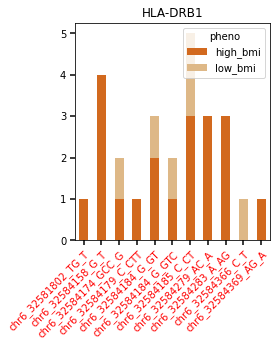

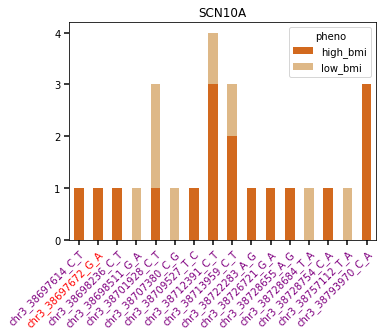

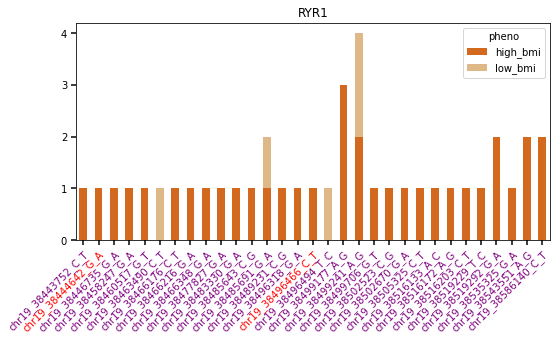

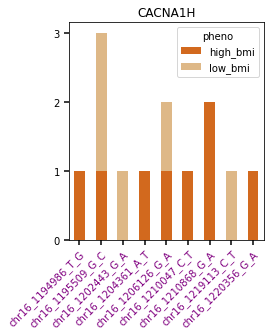

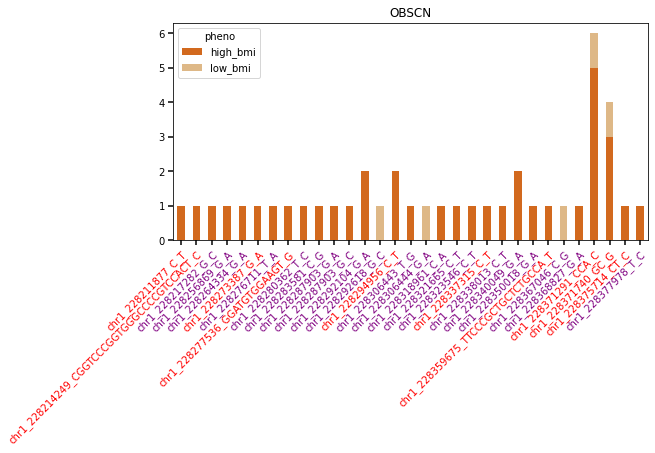

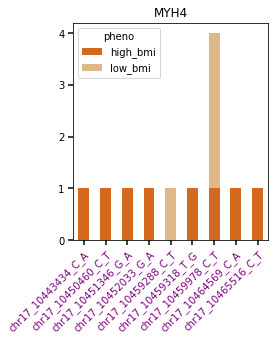

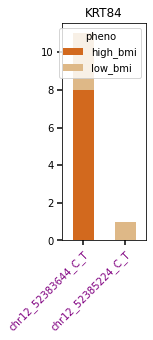

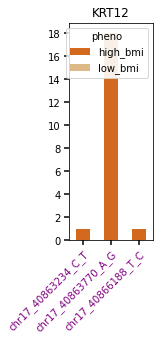

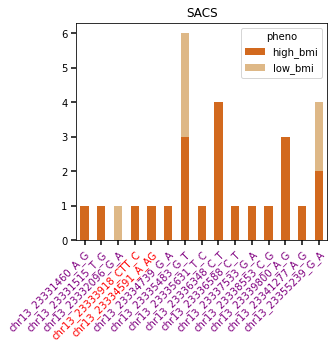

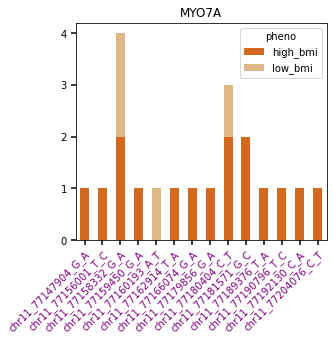

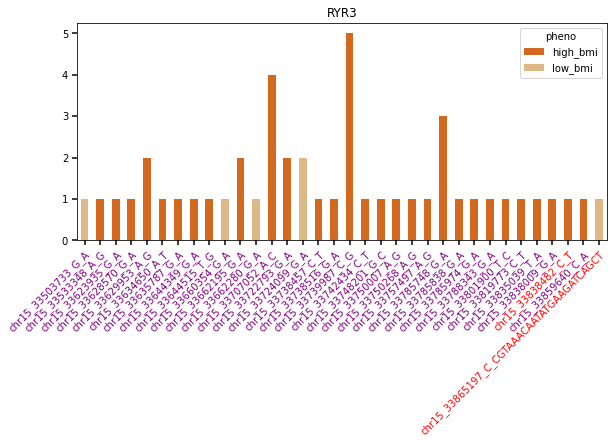

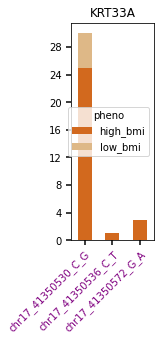

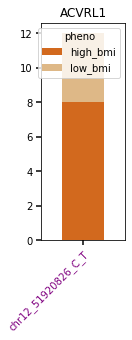

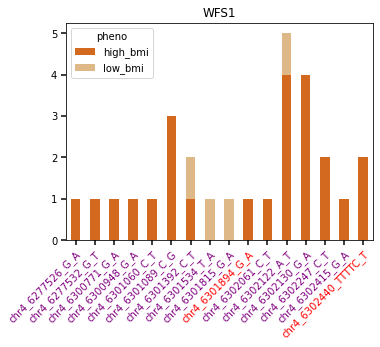

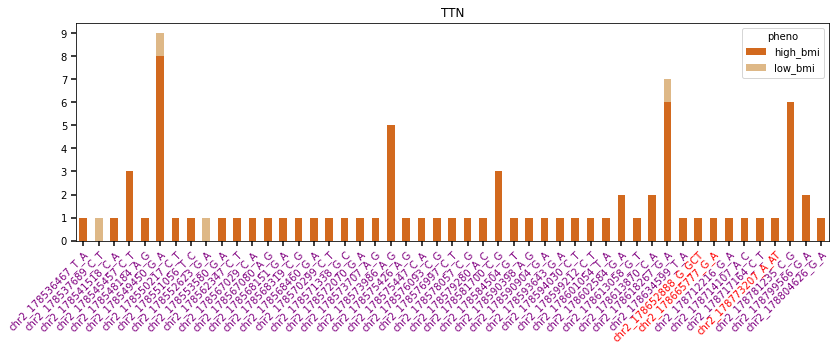

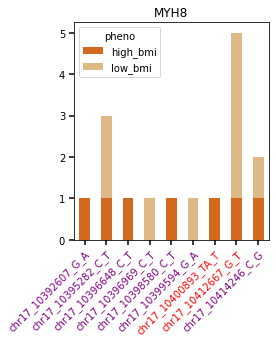

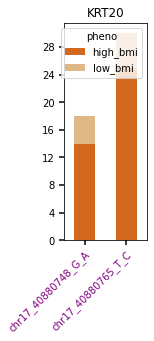

In [14]:
for g in both_pheno_genes:
    g_combo = get_gene_specific_combo_info(both_pheno_df, g)
    high_bmi_cases, low_bmi_cases = get_case_samples(g_combo)
    high_bmi_var_df = variants_df.loc[(variants_df.Sample.isin(high_bmi_cases))&(variants_df.SYMBOL==g)]
    low_bmi_var_df = variants_df.loc[(variants_df.Sample.isin(low_bmi_cases))&(variants_df.SYMBOL==g)]
    create_var_loc_plot(high_bmi_var_df, low_bmi_var_df, g, figsavedir)

In [20]:
with open("/data5/deepro/ukbiobank/analysis/bmi_project/protective/data/tables/bothpheno.txt", "w") as f:
    for g in both_pheno_geneids:
        f.write(f"{g}\n")